In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix,roc_curve,auc,accuracy_score,roc_auc_score
from sklearn.metrics import classification_report

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

# Reading the data

In [2]:
# Train data
train=pd.read_csv(r'C:\Users\inbox\OneDrive\Documents\incomeTrain.data',names=['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'label'])
#train=pd.read_csv(r'C:\Users\inbox\OneDrive\Documents\incomeTrain1.data')
print(train.shape)
print(list(train.columns))

(32561, 15)
['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'label']


In [3]:
train.head(5)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
#Identifying the data types
train.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
label             object
dtype: object

In [5]:
#Checking for missing values in train data
train.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
label             0
dtype: int64

# We will use K-means Clustering technique to create a column inorder to identify the clusters

In [6]:
numerical_data=train.loc[:,['age','fnlwgt','education_num','capital_gain','capital_loss','hours_per_week']]

In [7]:
#Importing the K-Means class
from sklearn.cluster import KMeans

wcss = []
#We will fit the kmeans algorithm to our data and then find the wcss for each number of clusters and 
#append it to the wcss list declared above
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init = 'k-means++',max_iter=300,n_init = 10,random_state=0)
    # the purpose of max_iter : Each time you click update centroids, a new iteration is performed. 
    #It makes sense, because when centroids are moved, distances to those centroids also change and some
    #points may change cluster.
    #n_init : the number of times k means algorithm will run with different initial centroids(default is 10)
    kmeans.fit(numerical_data)
    wcss.append(kmeans.inertia_) 
#We will then use the elbow method to determine the number of clusters

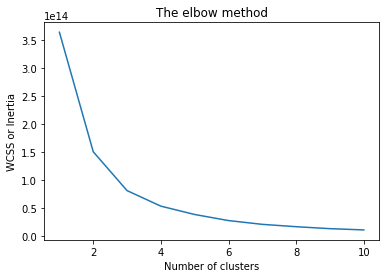

In [8]:
plt.plot(range(1,11),wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS or Inertia')
plt.show()

In [9]:
#the optimal number of clusters seems to be 2
kmeans = KMeans(n_clusters=2,init = 'k-means++',max_iter=300,n_init = 10,random_state=0)
y_kmeans = kmeans.fit_predict(numerical_data)

In [10]:
y_kmeans = pd.DataFrame(y_kmeans,columns=['cluster_id'],copy=True)

In [11]:
# Final training dataframe
# Merging the cluster column with the rest of the data
traindf = pd.merge(train, y_kmeans, left_index=True, right_index=True)
traindf.head(5)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,label,cluster_id
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,1


# Exploratory data analysis

In [12]:
# Analyzing the distribution of the labels
traindf['label'].value_counts()

 <=50K    24720
 >50K      7841
Name: label, dtype: int64

***
<strong>Label Encoding the target variable</strong>

In [13]:
# Label encoding the target variable
from sklearn.preprocessing import LabelEncoder
Encoder = LabelEncoder()
traindf['encoded_labels'] = Encoder.fit_transform(traindf['label'])

- 0 is the label for income <= 50K
- 1 is the label for income > 50K

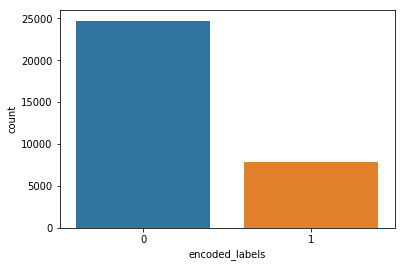

In [14]:
sns.countplot(x='encoded_labels',data=traindf)
plt.show()

In [15]:
#calculating the proportion of labels in the target column
count_income_less=len(traindf[traindf['encoded_labels']==0])
count_income_more=len(traindf[traindf['encoded_labels']==1])
pct_income_less=count_income_less/(count_income_less+count_income_more)
print("Percentage of people who have income less than 50K is: ",pct_income_less * 100)
pct_income_more= count_income_more/(count_income_less+count_income_more)
print("Percentage of people who have income more than 50K is: ",pct_income_more * 100)

Percentage of people who have income less than 50K is:  75.91904425539757
Percentage of people who have income more than 50K is:  24.080955744602438


- 7841 out of 32561 people have salary > 50k
- 24720 out of 32561 people have salary <= 50k
- Total 75.91% of the data belongs to the majority class
- Classes are imbalanced

***
<strong>Exploring the numerical columns</strong>

In [16]:
train.groupby('label').mean()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
label,,,,,,
<=50K,36.783738,190340.86517,9.595065,148.752468,53.142921,38.840210
>50K,44.249841,188005.00000,11.611657,4006.142456,195.001530,45.473026


In [17]:
train.groupby('label').median()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
label,,,,,,
<=50K,34,179465,9,0,0,40
>50K,44,176101,12,0,0,40


#### Observation:

- Average age of people earning more than 50K is more than people earning less than 50K.
- Average Education of people earning more than 50K is more than people earning less than 50K.
- Average Capital gains of people earning more than 50K are higher than people earning less than 50K.
- Average Capital losses of people earning more than 50K are higher than people earning less than 50K.
- Average working hours of people earning more than 50K are higher than people earning less than 50K.
- Only age,fnlwgt,education_num,hours_per_week can be analyzed for outlier detection.

In [18]:
train.describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


### Outlier detection and treatment

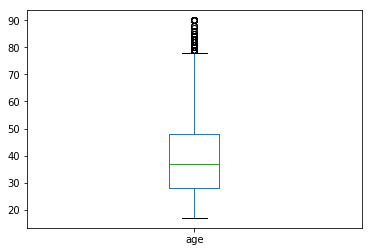

In [19]:
# For age
traindf['age'].plot.box() 
plt.show()

In [20]:
Q1 = traindf['age'].quantile(0.25)
Q3 = traindf['age'].quantile(0.75)
IQR = Q3 - Q1
noOfOutliers=((traindf['age'] < (Q1 - 1.5 * IQR)) | (traindf['age'] > (Q3 + 1.5 * IQR))).sum()
print('Percantage of outliers in age is:',(noOfOutliers/traindf.shape[0])*100)

Percantage of outliers in age is: 0.4391757009919842


In [21]:
# Removing rows with outliers in age
traindf = traindf.loc[(traindf['age'] >= (Q1 - 1.5 * IQR)) & (traindf['age'] <= (Q3 + 1.5 * IQR))]

- Such a small percentage of outliers is insignificant so we can remove those rows(less than 10%).

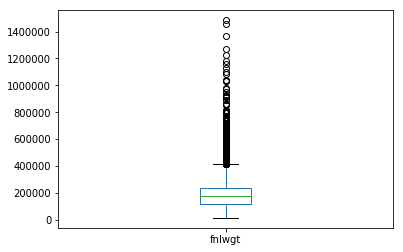

In [22]:
# For fnlwgt
traindf['fnlwgt'].plot.box() 
plt.show()

In [23]:
Q1 = traindf['fnlwgt'].quantile(0.25)
Q3 = traindf['fnlwgt'].quantile(0.75)
IQR = Q3 - Q1
noOfOutliers=((traindf['fnlwgt'] < (Q1 - 1.5 * IQR)) | (traindf['fnlwgt'] > (Q3 + 1.5 * IQR))).sum()
print('Percantage of outliers in fnlwgt is:',(noOfOutliers/traindf.shape[0])*100)

Percantage of outliers in fnlwgt is: 3.0260966129927818


In [24]:
# Removing rows with outliers in fnlwgt
traindf = traindf.loc[(traindf['fnlwgt'] >= (Q1 - 1.5 * IQR)) & (traindf['fnlwgt'] <= (Q3 + 1.5 * IQR))]

- Such a small percentage of outliers is insignificant so we can remove those rows(less than 10%).

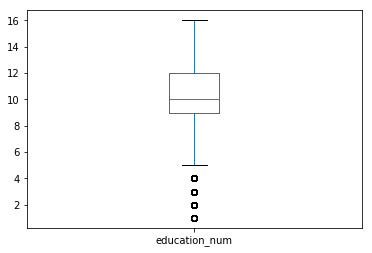

In [25]:
# For education_num
traindf['education_num'].plot.box() 
plt.show()

In [26]:
Q1 = traindf['education_num'].quantile(0.25)
Q3 = traindf['education_num'].quantile(0.75)
IQR = Q3 - Q1
noOfOutliers=((traindf['education_num'] < (Q1 - 1.5 * IQR)) | (traindf['education_num'] > (Q3 + 1.5 * IQR))).sum()
print('Percantage of outliers in education_num is:',(noOfOutliers/traindf.shape[0])*100)

Percantage of outliers in education_num is: 3.5499570569710848


In [27]:
traindf = traindf.loc[(traindf['education_num'] >= (Q1 - 1.5 * IQR)) & (traindf['education_num'] <= (Q3 + 1.5 * IQR))]

- Such a small percentage of outliers is insignificant so we can remove those rows(less than 10%).

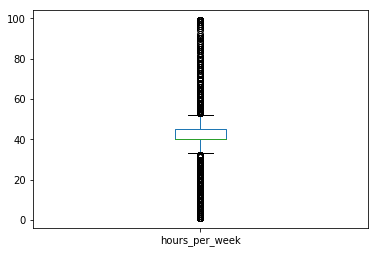

In [28]:
# For hours_per_week
traindf['hours_per_week'].plot.box() 
plt.show()

In [29]:
Q1 = traindf['hours_per_week'].quantile(0.25)
Q3 = traindf['hours_per_week'].quantile(0.75)
IQR = Q3 - Q1
noOfOutliers=((traindf['hours_per_week'] < (Q1 - 1.5 * IQR)) | (traindf['hours_per_week'] > (Q3 + 1.5 * IQR))).sum()
print('Percantage of outliers in hours_per_week is:',(noOfOutliers/traindf.shape[0])*100)

Percantage of outliers in hours_per_week is: 27.581544144322418


- This is a significant percentage so we will treat it.

In [30]:
median=traindf['hours_per_week'].median()
def outlierTreatment(x):
    if(x < (Q1 - 1.5 * IQR) or x > (Q3 + 1.5 * IQR)):
        return median
    else:
        return x

In [31]:
# Treatment of the above found outliers in hours_per_week variable
traindf['hours_per_week'] = traindf['hours_per_week'].apply(outlierTreatment)

In [32]:
noOfOutliers=((traindf['hours_per_week'] < (Q1 - 1.5 * IQR)) | (traindf['hours_per_week'] > (Q3 + 1.5 * IQR))).sum()
print('Percantage of outliers in hours_per_week is:',(noOfOutliers/traindf.shape[0])*100)

Percantage of outliers in hours_per_week is: 0.0


***
<strong>Exploring the categorical columns</strong>

In [33]:
# Removing education from our dataframe as a numerical variable is present for education
traindf.drop(["education"], axis = 1, inplace = True)

In [34]:
# Exploring workclass

# Replacing '?' in the dataframe with 'Unknown'
traindf['workclass'] = traindf['workclass'].apply(lambda s: s.replace('?', 'Unknown'))

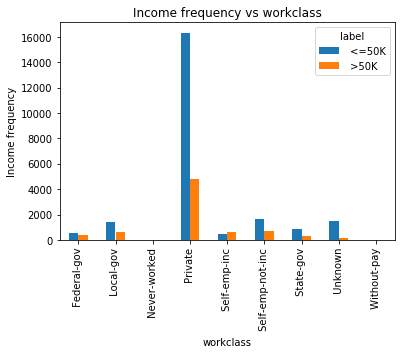

In [35]:
%matplotlib inline
pd.crosstab(traindf.workclass,traindf.label).plot(kind='bar')
plt.title('Income frequency vs workclass')
plt.xlabel('workclass')
plt.ylabel('Income frequency')
plt.show()

- The income frequency is varying with the workclass so it can be a good predictor variable

In [36]:
# Exploring marital_status

# Replacing '?' in the dataframe with 'Unknown'
traindf['marital_status'] = traindf['marital_status'].apply(lambda s: s.replace('?', 'Unknown'))

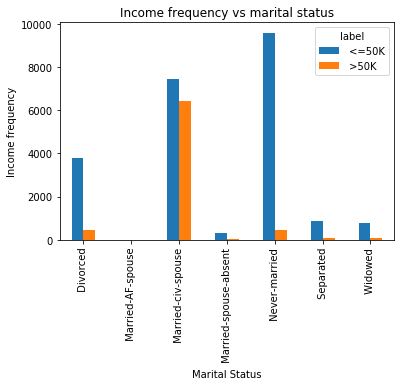

In [37]:
%matplotlib inline
pd.crosstab(traindf.marital_status,traindf.label).plot(kind='bar')
plt.title('Income frequency vs marital status')
plt.xlabel('Marital Status')
plt.ylabel('Income frequency')
plt.show()

- The income frequency is varying with the marital status so it can be a good predictor variable

In [38]:
# Exploring occupation

# Replacing '?' in the dataframe with 'Unknown'
traindf['occupation'] = traindf['occupation'].apply(lambda s: s.replace('?', 'Unknown'))

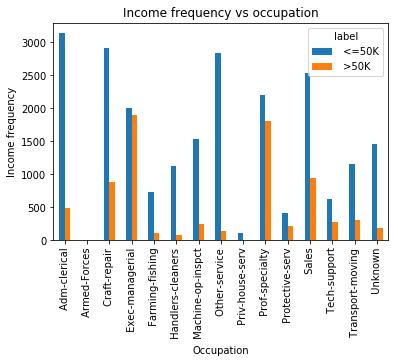

In [39]:
%matplotlib inline
pd.crosstab(traindf.occupation,traindf.label).plot(kind='bar')
plt.title('Income frequency vs occupation')
plt.xlabel('Occupation')
plt.ylabel('Income frequency')
plt.show()

- The income frequency is varying with the occupation so it can be a good predictor variable

In [40]:
# Exploring relationship

# Replacing '?' in the dataframe with 'Unknown'
traindf['relationship'] = traindf['relationship'].apply(lambda s: s.replace('?', 'Unknown'))

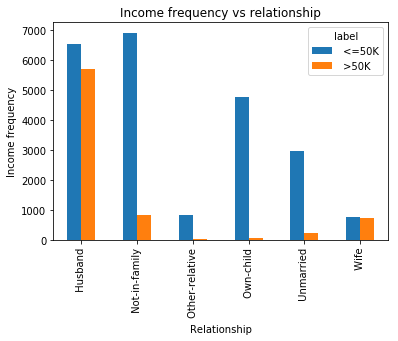

In [41]:
%matplotlib inline
pd.crosstab(traindf.relationship,traindf.label).plot(kind='bar')
plt.title('Income frequency vs relationship')
plt.xlabel('Relationship')
plt.ylabel('Income frequency')
plt.show()

- The income frequency is varying with the relationship so it can be a good predictor variable

In [42]:
# Exploring race

# Replacing '?' in the dataframe with 'Unknown'
traindf['race'] = traindf['race'].apply(lambda s: s.replace('?', 'Unknown'))

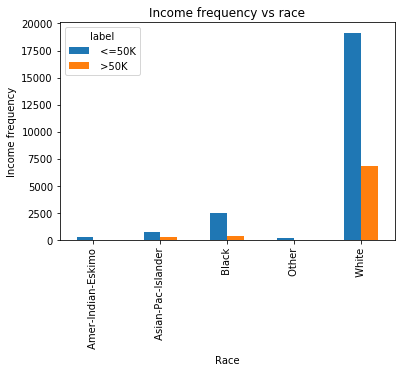

In [43]:
%matplotlib inline
pd.crosstab(traindf.race,traindf.label).plot(kind='bar')
plt.title('Income frequency vs race')
plt.xlabel('Race')
plt.ylabel('Income frequency')
plt.show()

- The income frequency is varying with the race so it can be a good predictor variable

In [44]:
# Exploring sex

# Replacing '?' in the dataframe with 'Unknown'
traindf['sex'] = traindf['sex'].apply(lambda s: s.replace('?', 'Unknown'))

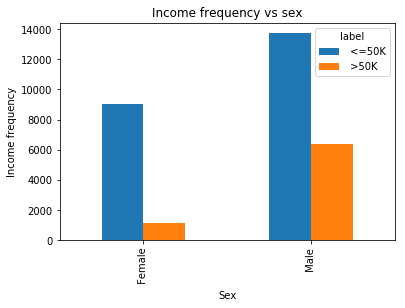

In [45]:
%matplotlib inline
pd.crosstab(traindf.sex,traindf.label).plot(kind='bar')
plt.title('Income frequency vs sex')
plt.xlabel('Sex')
plt.ylabel('Income frequency')
plt.show()

- The income frequency is varying with the sex so it can be a good predictor variable

In [46]:
# Exploring relationship

# Replacing '?' in the dataframe with 'Unknown'
traindf['native_country'] = traindf['native_country'].apply(lambda s: s.replace('?', 'Unknown'))

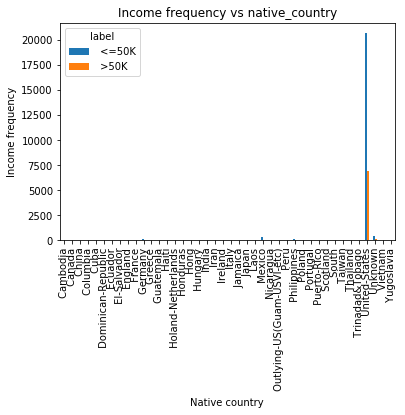

In [47]:
%matplotlib inline
pd.crosstab(traindf.native_country,traindf.label).plot(kind='bar')
plt.title('Income frequency vs native_country')
plt.xlabel('Native country')
plt.ylabel('Income frequency')
plt.show()

In [48]:
traindf['native_country'].value_counts()

 United-States                 27606
 Unknown                         524
 Mexico                          304
 Philippines                     185
 Germany                         132
 Canada                          114
 India                            99
 Puerto-Rico                      89
 England                          85
 Cuba                             80
 Jamaica                          80
 South                            78
 China                            69
 Vietnam                          62
 El-Salvador                      60
 Japan                            59
 Poland                           54
 Italy                            53
 Columbia                         53
 Dominican-Republic               51
 Taiwan                           50
 Iran                             42
 Haiti                            39
 Guatemala                        31
 France                           28
 Greece                           26
 Nicaragua                        26
 

- The distribution of data shows that native_country should not be included in model training as most of the data is for US.

In [49]:
# Removing native_country from our dataframe
traindf.drop(["native_country"], axis = 1, inplace = True)

In [50]:
traindf.shape

(30321, 15)

### Label encoding the categorical variables and preparing the final dataframe

In [51]:
# Label encoding the categorical variables
traindf['encoded_workclass'] = Encoder.fit_transform(traindf['workclass'])
traindf['encoded_marital_status'] = Encoder.fit_transform(traindf['marital_status'])
traindf['encoded_occupation'] = Encoder.fit_transform(traindf['occupation'])
traindf['encoded_relationship'] = Encoder.fit_transform(traindf['relationship'])
traindf['encoded_race'] = Encoder.fit_transform(traindf['race'])
traindf['encoded_sex'] = Encoder.fit_transform(traindf['sex'])

In [52]:
traindf.shape

(30321, 21)

- Variable 'fnlwgt' has not been included further to train the model because it seems to be some kind of id and is not           impacting the target variable

### Preparing the train and test data

In [53]:
# Train data
x_train = traindf.loc[:,['age','capital_gain','capital_loss','education_num','hours_per_week','cluster_id','encoded_workclass','encoded_marital_status','encoded_occupation','encoded_relationship','encoded_race','encoded_sex']]
y_train = traindf.loc[:,['encoded_labels']]

In [54]:
# Test data
test=pd.read_csv(r'C:\Users\inbox\OneDrive\Documents\incomeTest.test',names=['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'label'])

In [55]:
# Processing the test data

numerical_data=test.loc[:,['age','fnlwgt','education_num','capital_gain','capital_loss','hours_per_week']]
kmeans = KMeans(n_clusters=2,init = 'k-means++',max_iter=300,n_init = 10,random_state=0)
y_kmeans = kmeans.fit_predict(numerical_data)
y_kmeans = pd.DataFrame(y_kmeans,columns=['cluster_id'],copy=True)

# Merging the cluster column with the rest of the data
testdf = pd.merge(test, y_kmeans, left_index=True, right_index=True)

# Label encoding the categorical variables in test data
testdf['encoded_workclass'] = Encoder.fit_transform(testdf['workclass'])
testdf['encoded_marital_status'] = Encoder.fit_transform(testdf['marital_status'])
testdf['encoded_occupation'] = Encoder.fit_transform(testdf['occupation'])
testdf['encoded_relationship'] = Encoder.fit_transform(testdf['relationship'])
testdf['encoded_race'] = Encoder.fit_transform(testdf['race'])
testdf['encoded_sex'] = Encoder.fit_transform(testdf['sex'])
testdf['encoded_labels'] = Encoder.fit_transform(testdf['label'])

testdf.head(5)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,...,native_country,label,cluster_id,encoded_workclass,encoded_marital_status,encoded_occupation,encoded_relationship,encoded_race,encoded_sex,encoded_labels
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,...,United-States,<=50K.,1,4,4,7,3,2,1,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,...,United-States,<=50K.,1,4,2,5,0,4,1,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,...,United-States,>50K.,0,2,2,11,0,4,1,1
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,...,United-States,>50K.,1,4,2,7,0,2,1,1
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,...,United-States,<=50K.,1,0,4,0,3,4,0,0


In [56]:
x_test = testdf.loc[:,['age','capital_gain','capital_loss','education_num','hours_per_week','cluster_id','encoded_workclass','encoded_marital_status','encoded_occupation','encoded_relationship','encoded_race','encoded_sex']]
y_test = testdf.loc[:,['encoded_labels']]

# Applying SMOTE Technique
** Note : Apply SMOTE only on train data,because by oversampling only on the training data, none of the information in the test data is being used to create synthetic observations, therefore, no information will bleed from test data into the model training.

In [57]:
# Applying SMOTE
from sklearn.model_selection import train_test_split
os = SMOTE(random_state=0)
columns= x_train.columns

os_data_x,os_data_y=os.fit_sample(x_train, y_train)
os_data_x=pd.DataFrame(data=os_data_x, columns = columns)
os_data_y=pd.DataFrame(data=os_data_y,columns= ['label'])

print("length of oversampled data is: ",len(os_data_x))
print("Number of people having income <=50K in oversampled data: ",len(os_data_y[os_data_y['label']==0]))
print("Number of people having income >50K in oversampled data: ",len(os_data_y[os_data_y['label']==1]))
print("Proportion of people having income <=50K to people having income >50K in oversampled data is: ",len(os_data_y[os_data_y['label']==0])/len(os_data_x))
print("Proportion of people having income >50K to people having income <=50K in oversampled data is: ",len(os_data_y[os_data_y['label']==1])/len(os_data_x))

length of oversampled data is:  45546
Number of people having income <=50K in oversampled data:  22773
Number of people having income >50K in oversampled data:  22773
Proportion of people having income <=50K to people having income >50K in oversampled data is:  0.5
Proportion of people having income >50K to people having income <=50K in oversampled data is:  0.5


# Model training and evaluation

***********************
<strong>Building a Logistic Regression model</strong>

In [58]:
reg = linear_model.LogisticRegression() 
reg.fit(x_train, y_train) 
y_predicted_test = reg.predict(x_test) 

***********************
<strong>Evaluating the model</strong>

In [59]:
# Use accuracy_score function to get the accuracy
print("Logistic regression Accuracy Score -> ",accuracy_score(y_predicted_test, y_test)*100)

Logistic regression Accuracy Score ->  82.28610036238561


In [60]:
#Classification report
print(classification_report(y_test, y_predicted_test, target_names=Encoder.classes_))

              precision    recall  f1-score   support

      <=50K.       0.85      0.93      0.89     12435
       >50K.       0.68      0.47      0.55      3846

    accuracy                           0.82     16281
   macro avg       0.77      0.70      0.72     16281
weighted avg       0.81      0.82      0.81     16281



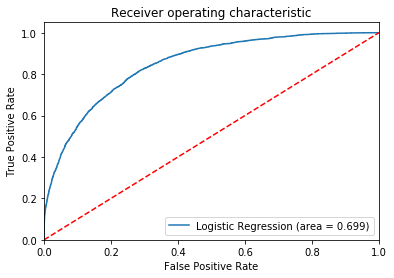

In [61]:
# AUC ROC for Logistic Regression

roc_auc = roc_auc_score(y_test, y_predicted_test)
fpr, tpr, thresholds = roc_curve(y_test, reg.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

- Logistic Regression gives an accuracy of 82.28% and area under ROC curve is 0.699

***********************
<strong>Building a Random Forest model</strong>

In [62]:
#Creating a Random forest object with a random state for reproducible results
clf = RandomForestClassifier(n_estimators=18, random_state=0)
#Training the model on train data
clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=18,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

***********************
<strong>Evaluating the model</strong>

In [63]:
# Use accuracy_score function to get the accuracy
y_predicted_test=clf.predict(x_test)
print("Random Forest Accuracy Score -> ",accuracy_score(y_predicted_test, y_test)*100)

Random Forest Accuracy Score ->  83.87691173760825


In [64]:
#Classification report
print(classification_report(y_test, y_predicted_test, target_names=Encoder.classes_))

              precision    recall  f1-score   support

      <=50K.       0.88      0.92      0.90     12435
       >50K.       0.69      0.59      0.63      3846

    accuracy                           0.84     16281
   macro avg       0.78      0.75      0.76     16281
weighted avg       0.83      0.84      0.83     16281



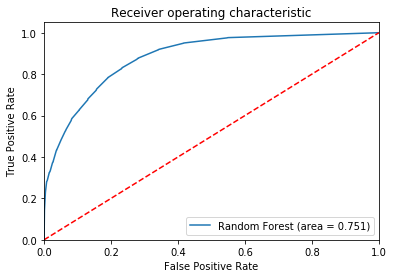

In [65]:
# AUC ROC for Random Forest

roc_auc = roc_auc_score(y_test, y_predicted_test)
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

- Random Forest gives an accuracy of 83.87% and area under ROC curve is 0.751

***********************
<strong>Building a xgboost classifier model</strong>

In [66]:
#Creating a xgboost classifier object with a random state for reproducible results
xg_clf = XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.9, learning_rate = 0.3,
                max_depth = 5, alpha = 10, n_estimators = 21)
#Training the model on train data
xg_clf.fit(x_train,y_train)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=21, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

***********************
<strong>Evaluating the model</strong>

In [67]:
# Use accuracy_score function to get the accuracy
y_predicted_test=xg_clf.predict(x_test)
print("xgboost Accuracy Score -> ",accuracy_score(y_predicted_test, y_test)*100)

xgboost Accuracy Score ->  86.04508322584607


In [68]:
#Classification report
print(classification_report(y_test, y_predicted_test, target_names=Encoder.classes_))

              precision    recall  f1-score   support

      <=50K.       0.88      0.95      0.91     12435
       >50K.       0.78      0.58      0.66      3846

    accuracy                           0.86     16281
   macro avg       0.83      0.76      0.79     16281
weighted avg       0.85      0.86      0.85     16281



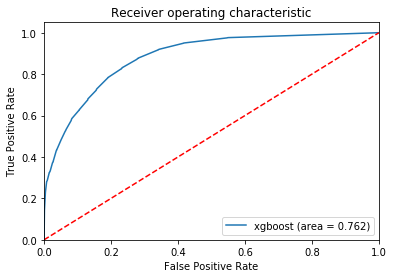

In [69]:
# AUC ROC for xgboost

roc_auc = roc_auc_score(y_test, y_predicted_test)
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='xgboost (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

- xgboost classifier gives an accuracy of 86.04% and area under ROC curve is 0.762

# Conclusion

- xgboost classifier is giving the best accuracy of 86.04% on the test data.
- The area under the ROC curve is 0.762